# Wrench estimation

In [2]:
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as Rot
from bagpy import bagreader
import numpy as np

## Extractors

In [3]:
def extract_odom(odom): 
    x = odom['pose.position.x']
    y = odom['pose.position.y']
    z = odom['pose.position.z']
    qx = odom['pose.orientation.x']
    qy = odom['pose.orientation.y']
    qz = odom['pose.orientation.z']
    qw = odom['pose.orientation.w']
    return x,y,z,qx,qy,qz,qw

def extract_nav_odom(nav_odom): 
    t = nav_odom['Time']
    x = nav_odom['pose.pose.position.x']
    y = nav_odom['pose.pose.position.y']
    z = nav_odom['pose.pose.position.z']
    qx = nav_odom['pose.pose.orientation.x']
    qy = nav_odom['pose.pose.orientation.y']
    qz = nav_odom['pose.pose.orientation.z']
    qw = nav_odom['pose.pose.orientation.w']
    return t, x,y,z,qx,qy,qz,qw

def extract_acc_cmd(df_acc_uav, t_end):
    t = df_acc_uav['Time']
    t = scale_time(t)
    ax = df_acc_uav['acceleration_semibody.x']
    ay = df_acc_uav['acceleration_semibody.y']
    az = df_acc_uav['acceleration_semibody.z']
    
    if t_end:
        it = find_closest_index(t, t_end); t = t[:it]; ax=ax[:it]; ay=ay[:it]; az=az[:it]
    
    return t, ax, ay, az

def extract_acc_meas(df_imu, t_end): 
    
    t = df_imu['Time']
    t = scale_time(t)
    ax = df_imu['linear_acceleration.x']
    ay = df_imu['linear_acceleration.y']
    az = df_imu['linear_acceleration.z']
    
    if t_end:
        it = find_closest_index(t, t_end); t = t[:it]; ax=ax[:it]; ay=ay[:it]; az=az[:it]
    
    return t, ax, ay, az

## Geometrical manipulation matrices

In [4]:
# Convert quaternion to the rotational matrix
def quat2rot(q):
    
    x, y, z, w = q
    r = Rot.from_quat([x, y, z, w])
    return r.as_matrix()

def get_yaw_from_rotation_matrix(R):
    """
    Extract the yaw angle from a 3x3 rotation matrix.
    
    Parameters:
    R -- A 3x3 numpy array representing the rotation matrix.
    
    Returns:
    Yaw angle in radians.
    """
    # Extract elements from the rotation matrix
    R11 = R[0, 0]
    R21 = R[1, 0]
    
    # Compute the yaw angle
    yaw = np.arctan2(R21, R11)
    
    return yaw

# Convert extracted odometry to the T
def convT(x,y,z,qx,qy,qz,qw): 
    R = quat2rot((qx, qy, qz, qw))
    p = np.array([x, y, z]).reshape(3, 1)
    T = np.hstack((R, p))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

# Create list from T
def create_T_list(x, y, z, qx, qy, qz, qw):
    T_list = []
    for x_,y_,z_,qx_,qy_,qz_,qw_ in zip(x,y,z,qx,qy,qz,qw): 
        T_ = convT(x_,y_,z_, qx_,qy_,qz_,qw_)
        T_list.append(T_)
    return T_list

# Invert Ts in the list
def inv_T_list(T_list): 
    invT = []
    for T_ in T_list: 
        invT.append(np.linalg.inv(T_))
    return invT

# Calibrate end effector [Check this part]
def calibrate_ee(T_uav, T_ee):
    T_list = []
    for T, T_inv in zip(T_ee, inv_T_list(T_uav)):
        T_mut = np.matmul(T_inv, T)
        T_new = np.round(T_mut, 4)
        T_list.append(T_new)
    return T_list

def calibrate_ee(T_uav, T_ee):
    T_list = []
    for T, T_inv in zip(T_ee, T_uav): 
        T_mut = np.matmul(T_inv, T)
        T_new = np.round(T_mut, 4)
        T_list.append(T_new)
    return T_list

# Load the bag file [Create T_uav, T_ee, and T_calib] lists
def get_Ts(bag_pth): 
    bag = bagreader(bag_pth)

    # Read the specific topic, replace '/poseStamped_topic' with your topic name
    pose_uav = bag.message_by_topic('/mocap_helper/opt_elios_pose')
    pose_ee = bag.message_by_topic('/mocap_helper/opt_ee_pose')
    df_uav = pd.read_csv(pose_uav)
    df_ee = pd.read_csv(pose_ee)

    x,y,z,qx,qy,qz,qw = extract_odom(df_uav)
    x_ee, y_ee, z_ee, qx_ee, qy_ee, qz_ee, qw_ee = extract_odom(df_ee)

    T_uav = create_T_list(x, y, z, qx, qy, qz, qw)
    T_ee = create_T_list(x_ee, y_ee, z_ee, qx_ee, qy_ee, qz_ee, qw_ee)
    T_calib = calibrate_ee(T_uav, T_ee)
    return T_uav, T_ee, T_calib

# Rotation matrices average 
def avg_T(T_calib): 
    x_ = [T_[0, 3] for T_ in T_calib]
    y_ = [T_[1, 3] for T_ in T_calib]
    z_ = [T_[2, 3] for T_ in T_calib]
    plot_p(x_, y_, z_)

    x_mean = np.mean(x_)
    y_mean = np.mean(y_)
    z_mean = np.mean(z_)
    p_mean = np.array([x_mean, y_mean, z_mean]).reshape(3, 1)

    T_calib_ = np.hstack((np.eye(3), p_mean))
    T_calib_ = np.vstack((T_calib_, [0, 0, 0, 1]))
    return T_calib_

def get_est(T_uav, T_): 
    newT_ = []
    for Tu in T_uav:
        newT = np.matmul(Tu, T_)
        newT_.append(newT)
        
    x_ = [T_[0, 3] for T_ in newT_]
    y_ = [T_[1, 3] for T_ in newT_]
    z_ = [T_[2, 3] for T_ in newT_] 
    
    return x_, y_, z_

## Utils


In [5]:
# Convert quaternion to the rotational matrix
def quat2rot(q):
    
    x, y, z, w = q
    r = Rot.from_quat([x, y, z, w])
    return r.as_matrix()

def get_yaw_from_rotation_matrix(R):
    """
    Extract the yaw angle from a 3x3 rotation matrix.
    
    Parameters:
    R -- A 3x3 numpy array representing the rotation matrix.
    
    Returns:
    Yaw angle in radians.
    """
    # Extract elements from the rotation matrix
    R11 = R[0, 0]
    R21 = R[1, 0]
    
    # Compute the yaw angle
    yaw = np.arctan2(R21, R11)
    
    return yaw

# Convert extracted odometry to the T
def convT(x,y,z,qx,qy,qz,qw): 
    R = quat2rot((qx, qy, qz, qw))
    p = np.array([x, y, z]).reshape(3, 1)
    T = np.hstack((R, p))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

# Create list from T
def create_T_list(x, y, z, qx, qy, qz, qw):
    T_list = []
    for x_,y_,z_,qx_,qy_,qz_,qw_ in zip(x,y,z,qx,qy,qz,qw): 
        T_ = convT(x_,y_,z_, qx_,qy_,qz_,qw_)
        T_list.append(T_)
    return T_list

# Invert Ts in the list
def inv_T_list(T_list): 
    invT = []
    for T_ in T_list: 
        invT.append(np.linalg.inv(T_))
    return invT

# Calibrate end effector [Check this part]
def calibrate_ee(T_uav, T_ee):
    T_list = []
    for T, T_inv in zip(T_ee, inv_T_list(T_uav)):
        T_mut = np.matmul(T_inv, T)
        T_new = np.round(T_mut, 4)
        T_list.append(T_new)
    return T_list

def calibrate_ee(T_uav, T_ee):
    T_list = []
    for T, T_inv in zip(T_ee, T_uav): 
        T_mut = np.matmul(T_inv, T)
        T_new = np.round(T_mut, 4)
        T_list.append(T_new)
    return T_list

# Load the bag file [Create T_uav, T_ee, and T_calib] lists
def get_Ts(bag_pth): 
    bag = bagreader(bag_pth)

    # Read the specific topic, replace '/poseStamped_topic' with your topic name
    pose_uav = bag.message_by_topic('/mocap_helper/opt_elios_pose')
    pose_ee = bag.message_by_topic('/mocap_helper/opt_ee_pose')
    df_uav = pd.read_csv(pose_uav)
    df_ee = pd.read_csv(pose_ee)

    x,y,z,qx,qy,qz,qw = extract_odom(df_uav)
    x_ee, y_ee, z_ee, qx_ee, qy_ee, qz_ee, qw_ee = extract_odom(df_ee)

    T_uav = create_T_list(x, y, z, qx, qy, qz, qw)
    T_ee = create_T_list(x_ee, y_ee, z_ee, qx_ee, qy_ee, qz_ee, qw_ee)
    T_calib = calibrate_ee(T_uav, T_ee)
    return T_uav, T_ee, T_calib

# Rotation matrices average 
def avg_T(T_calib): 
    x_ = [T_[0, 3] for T_ in T_calib]
    y_ = [T_[1, 3] for T_ in T_calib]
    z_ = [T_[2, 3] for T_ in T_calib]
    plot_p(x_, y_, z_)

    x_mean = np.mean(x_)
    y_mean = np.mean(y_)
    z_mean = np.mean(z_)
    p_mean = np.array([x_mean, y_mean, z_mean]).reshape(3, 1)

    T_calib_ = np.hstack((np.eye(3), p_mean))
    T_calib_ = np.vstack((T_calib_, [0, 0, 0, 1]))
    return T_calib_

def get_est(T_uav, T_): 
    newT_ = []
    for Tu in T_uav:
        newT = np.matmul(Tu, T_)
        newT_.append(newT)
        
    x_ = [T_[0, 3] for T_ in newT_]
    y_ = [T_[1, 3] for T_ in newT_]
    z_ = [T_[2, 3] for T_ in newT_] 
    
    return x_, y_, z_

## Wrench estimation procedure

In [6]:
bag1 = bagreader("./bags/flynav_2409_wall_touch.bag")
bag2 = bagreader("./bags/flynav_2409_wall_touch_procedure.bag")

[INFO]  Data folder ./bags/flynav_2409_wall_touch already exists. Not creating.
[INFO]  Data folder ./bags/flynav_2409_wall_touch_procedure already exists. Not creating.


In [7]:
imu_ = bag1.message_by_topic('/sensors/imu')
kalman_ = bag1.message_by_topic('/kalman_scan2map_node/odometry_ros')
vio_ = bag1.message_by_topic('/flynav/vio_odom')
ctl_cmd_ = bag1.message_by_topic('/flyanav/controller/command')

In [8]:
imu_ = pd.read_csv(imu_)
kalman_ = pd.read_csv(kalman_)
vio_ = pd.read_csv(vio_)
ctl_cmd_ = pd.read_csv(ctl_cmd_)

In [12]:
def wrench_estimation(bag_pth, m):
    bag1 = bagreader(bag_pth)
    imu_ = bag1.message_by_topic('/sensors/imu')
    kalman_ = bag1.message_by_topic('/kalman_scan2map_node/odometry_ros')
    vio_ = bag1.message_by_topic('/flynav/vio_odom')
    ctl_cmd_ = bag1.message_by_topic('/flyanav/controller/command')
    imu_ = pd.read_csv(imu_)
    kalman_ = pd.read_csv(kalman_)
    vio_ = pd.read_csv(vio_)
    ctl_cmd_ = pd.read_csv(ctl_cmd_)
    qx = kalman_['pose.pose.orientation.x']
    qy = kalman_['pose.pose.orientation.y']
    qz = kalman_['pose.pose.orientation.z']
    qw = kalman_['pose.pose.orientation.w']
    R_ = [quat2rot((qx_, qy_, qz_, qw_)) for qx_, qy_, qz_, qw_ in zip(qx, qy, qz, qw)]
    ax = imu_['linear_acceleration.x']
    ay = imu_['linear_acceleration.y']
    az = imu_['linear_acceleration.z']
    a = [np.array([ax_, ay_, az_]) for ax_, ay_, az_ in zip(ax, ay, az)]
    cax = ctl_cmd_['acceleration_semibody.x']
    cay = ctl_cmd_['acceleration_semibody.y']
    caz = ctl_cmd_['acceleration_semibody.z']
    ca = [np.array([cax_, cay_, caz_]) for cax_, cay_, caz_ in zip(cax, cay, caz)]

    r1 = round(len(ax)/len(R_))
    r2 = round(len(cay)/len(R_))

    a = a[::r1][:len(R_)]
    ca = ca[::r2][:len(R_)]

    fcs = []
    for a_, ca_, R in zip (a, ca, R_): 
        f = m * (np.matmul(R, a_) - np.matmul(R, ca_))
        fcs.append(f)
    
    return fcs

def plot_wrench(fcs, xsize=15, ysize=10): 
    fx_ = [f[0] for f in fcs]
    fy_ = [f[1] for f in fcs]
    fz_ = [f[2] for f in fcs]
    
    plt.figure(figsize=(xsize, ysize))
    plt.plot(range(0, len(fcs)), fx_, color='r', label='fx')
    plt.plot(range(0, len(fcs)), fy_, color='g', label='fy')
    plt.plot(range(0, len(fcs)), fz_, color='b', label='fz')
    plt.grid()
    plt.legend()
    plt.xlabel('n')
    plt.ylabel('F [N]')
    plt.xlim(0, len(fx_))  # This sets the x-axis range from 0 to 6

[INFO]  Data folder ./bags/flynav_2409_wall_touch already exists. Not creating.


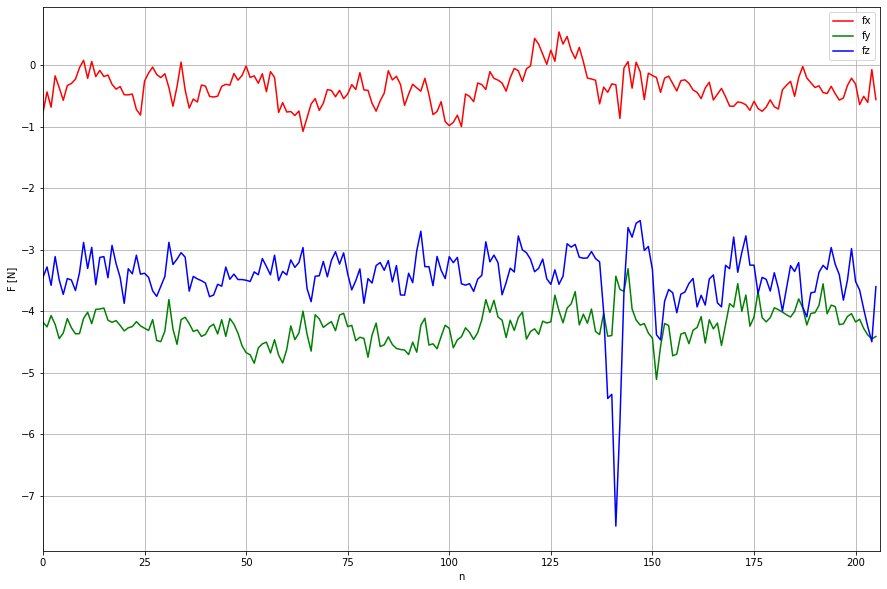

In [13]:
fcs = wrench_estimation("./bags/flynav_2409_wall_touch.bag", 2.35)
plot_wrench(fcs)

[INFO]  Data folder ./bags/flynav_2409_wall_touch_procedure already exists. Not creating.


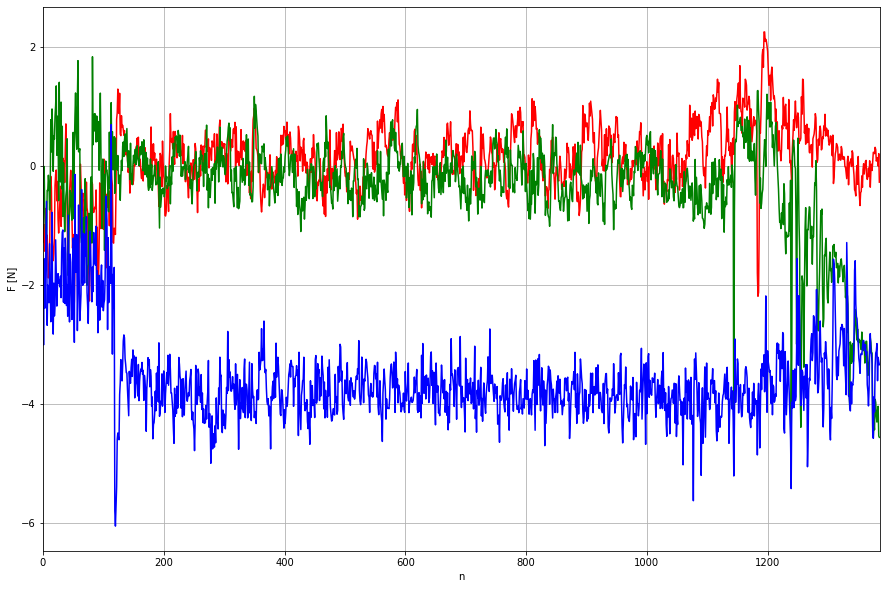

In [40]:
fcs = wrench_estimation("./bags/flynav_2409_wall_touch_procedure.bag", 2.35)
plot_wrench(fcs)  

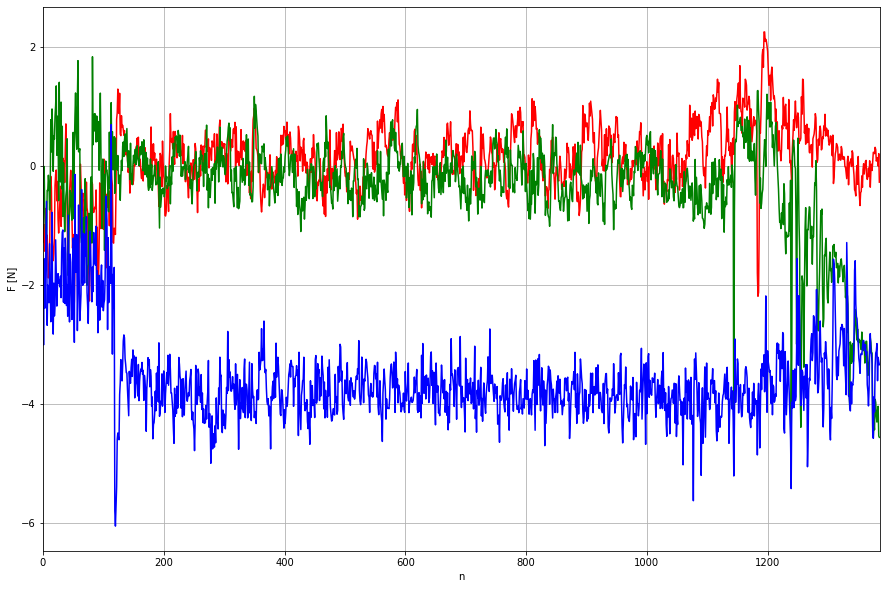

In [41]:
plot_wrench(fcs)

# TODO: 
- [ ] Check filtered wrench estimation

[INFO]  Data folder ./bags/stable_vs_unstable_contact already exists. Not creating.


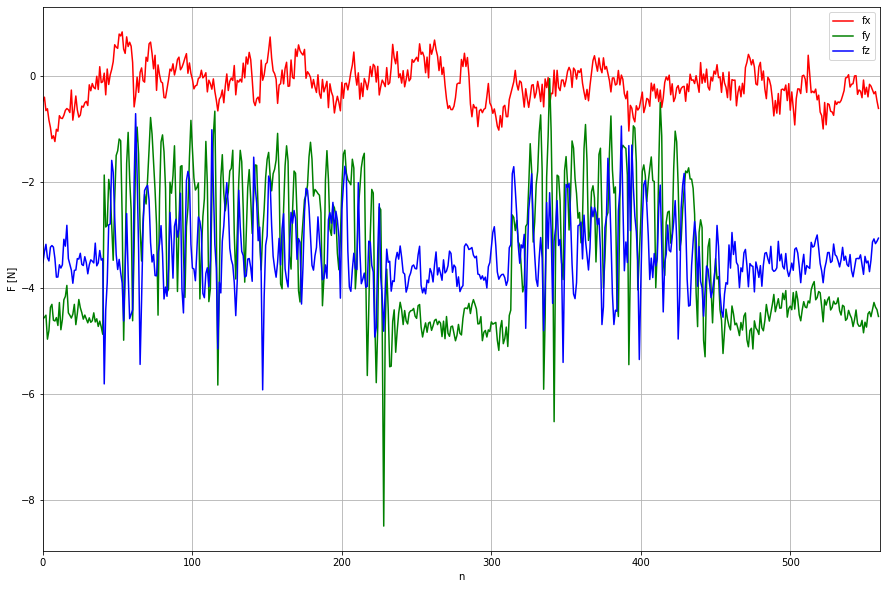

In [14]:
fcs = wrench_estimation("./bags/stable_vs_unstable_contact.bag", 2.35)
plot_wrench(fcs)  

In [16]:
nbag = bagreader("./bags/flynav_2409_wall_touch_procedure.bag")

[INFO]  Data folder ./bags/flynav_2409_wall_touch_procedure already exists. Not creating.


In [21]:
nbag.topic_table
state_ = pd.read_csv(nbag.message_by_topic('/state'))

In [34]:
state_dict = {"IDLE": 0, "TAKE_OFF": 1, "YAW_IN": 2, "GO_TO_POSE": 3, "TOUCH_WALL": 4, "YAW": 5, "SET_YAW": 6}

In [35]:
a = state_['data']
num_state = [state_dict[state_] for state_ in a] 


In [36]:
print(num_state)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 